In [ ]:
# Install Kaggle package
!pip install kaggle

# Create Kaggle directory and copy API key
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

# Download the dataset from Kaggle
!kaggle datasets download -d nelakurthisudheer/dataset-for-predicting-watering-the-plants

# Unzip the dataset
!unzip dataset-for-predicting-watering-the-plants.zip

print('Data source import complete.')

Dataset URL: https://www.kaggle.com/datasets/nelakurthisudheer/dataset-for-predicting-watering-the-plants
License(s): unknown
  0% 0.00/856k [00:00<?, ?B/s]
100% 856k/856k [00:00<00:00, 40.1MB/s]
Archive:  dataset-for-predicting-watering-the-plants.zip
  inflating: TARP.csv                
Data source import complete.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score

In [ ]:
df = pd.read_csv('TARP.csv')
df.head()

,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K,Status
0,54,22,70,21,19.52,2.13,55.04,6.30,101.50,6.502985,202.935536,90.0,42.0,43.0,ON
1,12,20,40,104,19.49,2.01,55.17,10.46,101.50,7.038096,226.655537,85.0,58.0,41.0,OFF
2,34,26,35,62,19.47,1.90,55.30,14.63,101.51,7.840207,263.964248,60.0,55.0,44.0,ON
3,7,44,44,93,19.54,2.28,54.20,16.08,101.51,6.980401,242.864034,74.0,35.0,40.0,OFF
4,50,38,23,92,19.61,2.66,53.09,17.52,101.51,7.628473,262.717340,78.0,42.0,42.0,OFF


In [ ]:
encoder = LabelBinarizer()
df['Status'] = encoder.fit_transform(df['Status'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Soil Moisture        100000 non-null  int64  
 1   Temperature          100000 non-null  int64  
 2    Soil Humidity       100000 non-null  int64  
 3   Time                 100000 non-null  int64  
 4   Air temperature (C)  23995 non-null   float64
 5   Wind speed (Km/h)    23995 non-null   float64
 6   Air humidity (%)     23995 non-null   float64
 7   Wind gust (Km/h)     23995 non-null   float64
 8   Pressure (KPa)       23995 non-null   float64
 9   ph                   2200 non-null    float64
 10  rainfall             2200 non-null    float64
 11  N                    2200 non-null    float64
 12  P                    2200 non-null    float64
 13  K                    2200 non-null    float64
 14  Status               100000 non-null  int64  
dtypes: float64(10), in

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Soil Moisture,100000.0,45.484070,25.993998,1.000000,23.000000,45.000000,68.000000,90.000000
Temperature,100000.0,22.536100,13.251352,0.000000,11.000000,23.000000,34.000000,45.000000
Soil Humidity,100000.0,45.016790,14.726676,20.000000,32.000000,45.000000,58.000000,70.000000
Time,100000.0,55.253650,32.093033,0.000000,28.000000,55.000000,83.000000,110.000000
Air temperature (C),23995.0,24.263780,6.756751,11.220000,18.580000,22.150000,29.590000,45.560000
Wind speed (Km/h),23995.0,9.896898,4.325666,0.000000,6.830000,9.530000,12.460000,31.360000
Air humidity (%),23995.0,58.521052,30.073448,0.590000,33.980000,61.310000,86.360000,96.000000
Wind gust (Km/h),23995.0,41.744905,24.168987,0.000000,21.820000,37.240000,59.275000,133.330000
Pressure (KPa),23995.0,101.131418,0.218448,100.500000,100.980000,101.120000,101.260000,101.860000
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091


In [ ]:
imputer = IterativeImputer(random_state=46, verbose=True)
data = imputer.fit_transform(df)
data = pd.DataFrame(data, columns = df.columns)
data.head()

[IterativeImputer] Completing matrix with shape (100000, 15)
[IterativeImputer] Change: 290.80942331563296, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 92.93743015114458, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 36.41378245598381, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 22.288778775594356, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 14.186852778424159, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 9.057472360287623, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 5.783789901162139, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 3.6933301763241007, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 2.3584320256080185, scaled tolerance: 0.2985601175 
[IterativeImputer] Change: 1.5060124036995655, scaled tolerance: 0.2985601175 


,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K,Status
0,54.0,22.0,70.0,21.0,19.52,2.13,55.04,6.30,101.50,6.502985,202.935536,90.0,42.0,43.0,1.0
1,12.0,20.0,40.0,104.0,19.49,2.01,55.17,10.46,101.50,7.038096,226.655537,85.0,58.0,41.0,0.0
2,34.0,26.0,35.0,62.0,19.47,1.90,55.30,14.63,101.51,7.840207,263.964248,60.0,55.0,44.0,1.0
3,7.0,44.0,44.0,93.0,19.54,2.28,54.20,16.08,101.51,6.980401,242.864034,74.0,35.0,40.0,0.0
4,50.0,38.0,23.0,92.0,19.61,2.66,53.09,17.52,101.51,7.628473,262.717340,78.0,42.0,42.0,0.0


<Axes: >

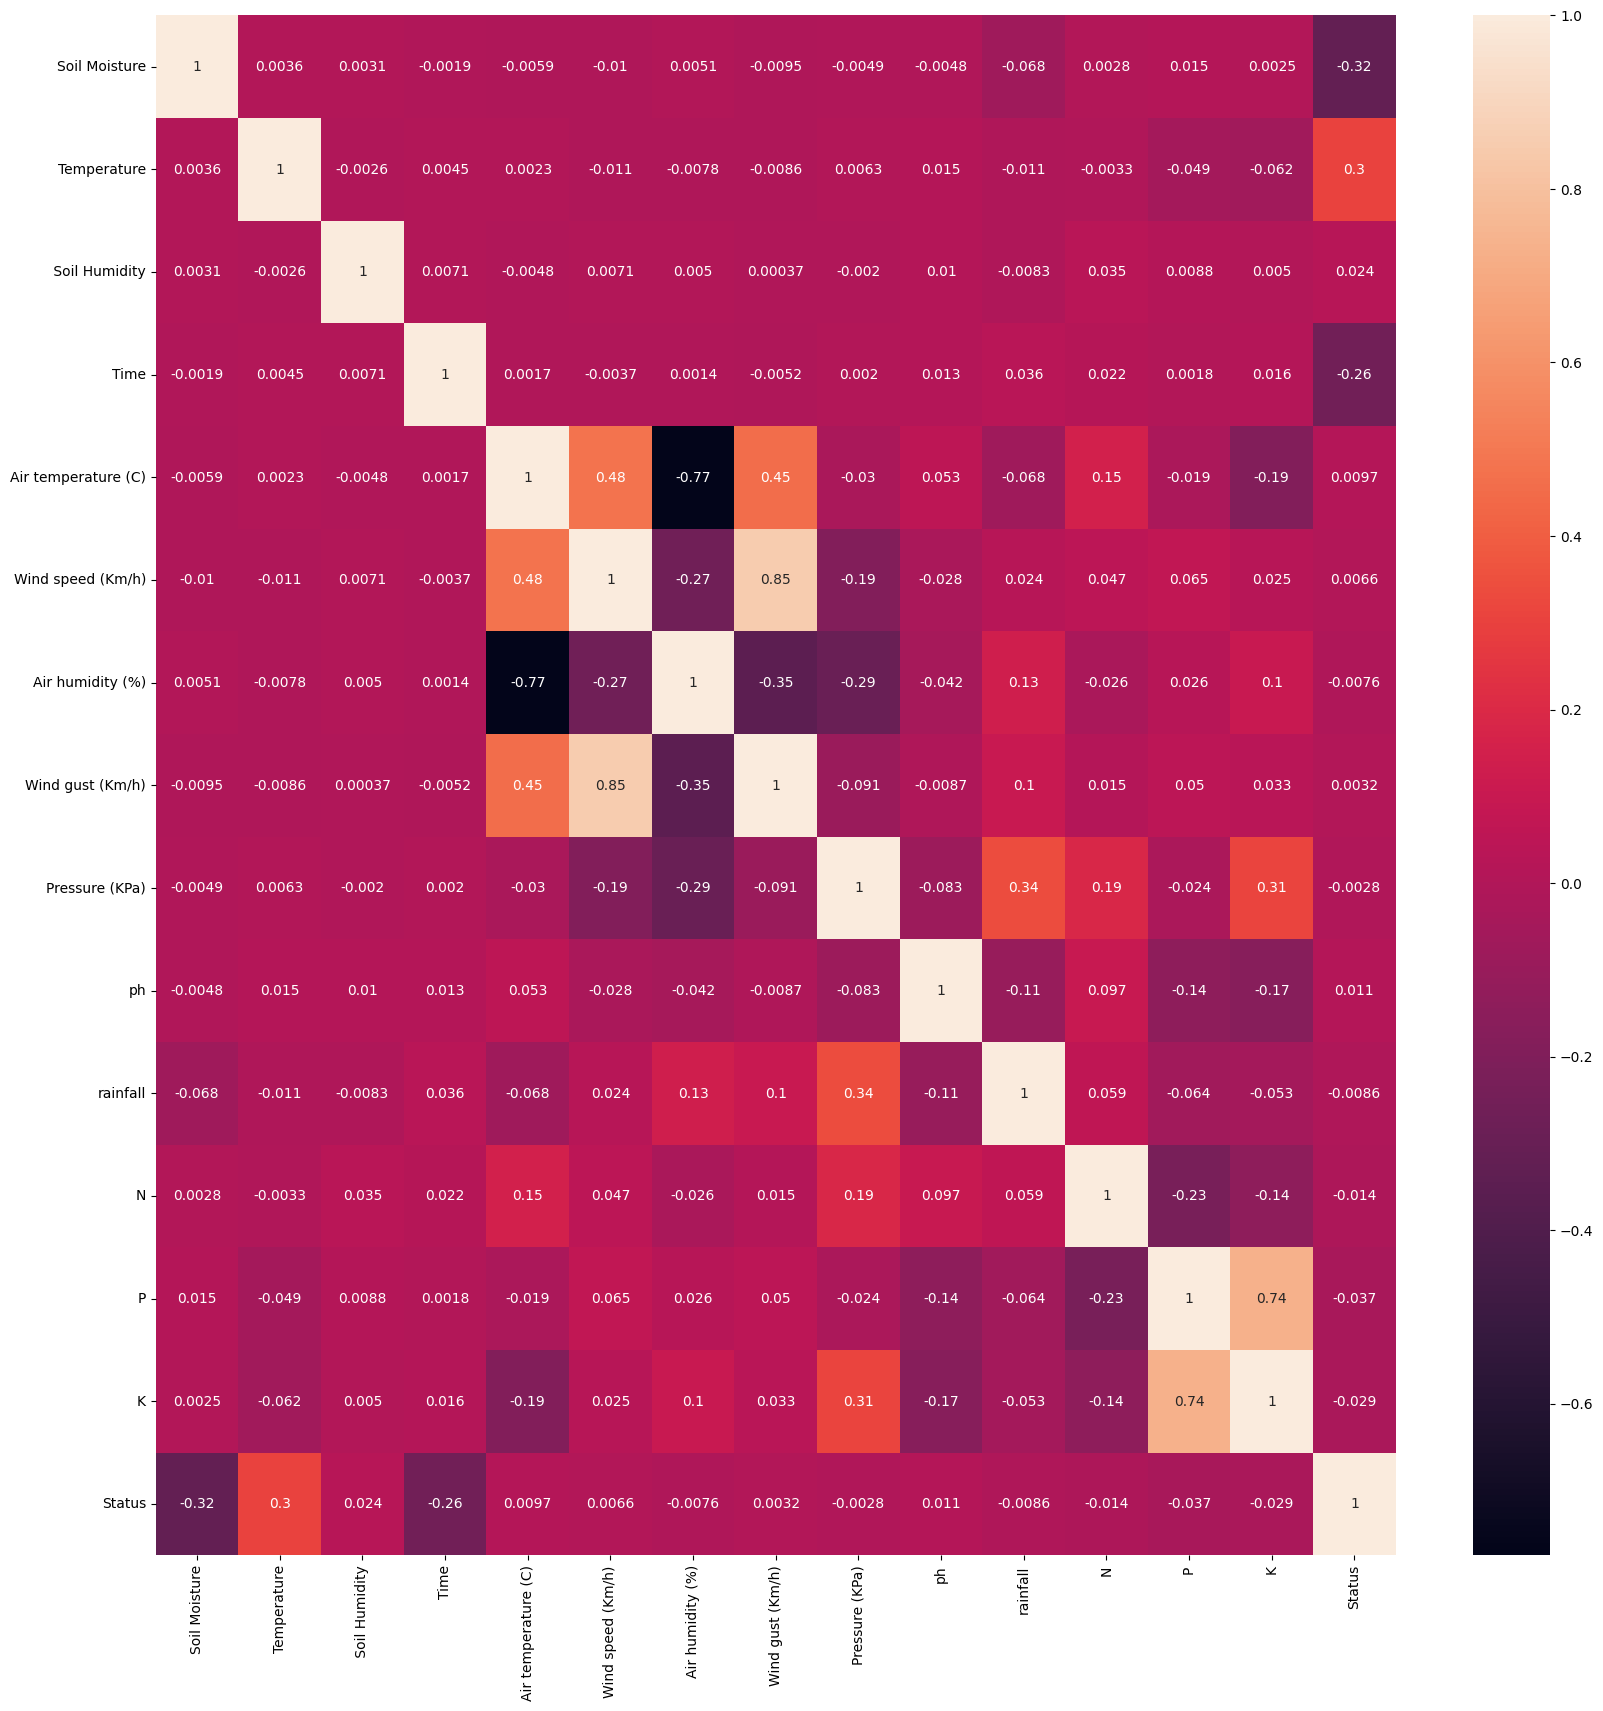

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,20))
corr = df.corr()
sns.heatmap(corr,annot=True)

In [ ]:
#scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1,1))
sdf = scaler.fit_transform(data.iloc[:,:-1], data.iloc[:,-1])
scaled_df = pd.DataFrame(sdf, columns = data.iloc[:,:-1].columns)
scaled_df['Status'] = data['Status']
scaled_df.head()

,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K,Status
0,0.191011,-0.022222,1.00,-0.618182,-0.516599,-0.864158,0.141390,-0.905498,0.470588,-0.067473,0.312916,0.285714,-0.471429,-0.247192,1.0
1,-0.752809,-0.111111,-0.20,0.890909,-0.518346,-0.871811,0.144115,-0.843096,0.470588,0.098961,0.483349,0.214286,-0.242857,-0.262589,0.0
2,-0.258427,0.155556,-0.40,0.127273,-0.519511,-0.878827,0.146840,-0.780545,0.485294,0.348438,0.751421,-0.142857,-0.285714,-0.239493,1.0
3,-0.865169,0.955556,-0.04,0.690909,-0.515434,-0.854592,0.123782,-0.758794,0.485294,0.081016,0.599811,0.057143,-0.571429,-0.270288,0.0
4,0.101124,0.688889,-0.88,0.672727,-0.511357,-0.830357,0.100514,-0.737193,0.485294,0.282583,0.742461,0.114286,-0.471429,-0.254891,0.0


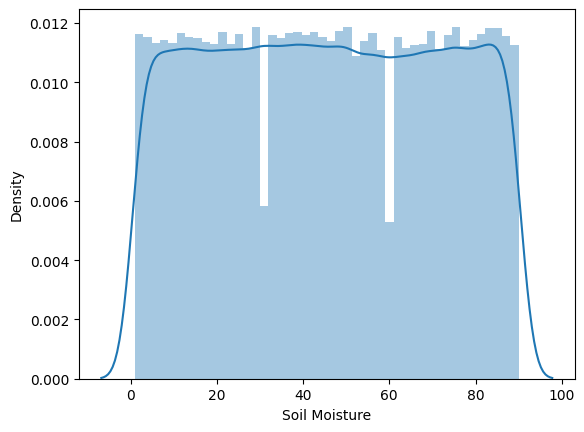

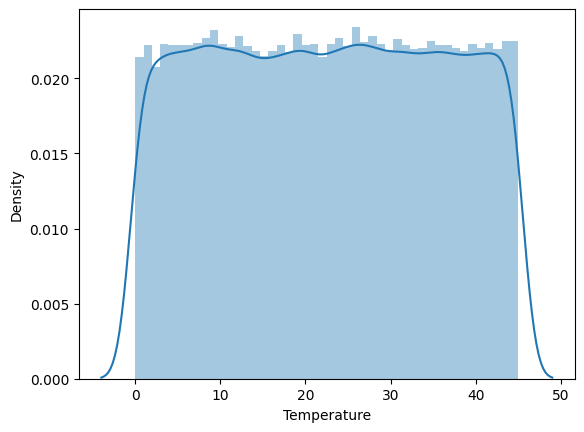

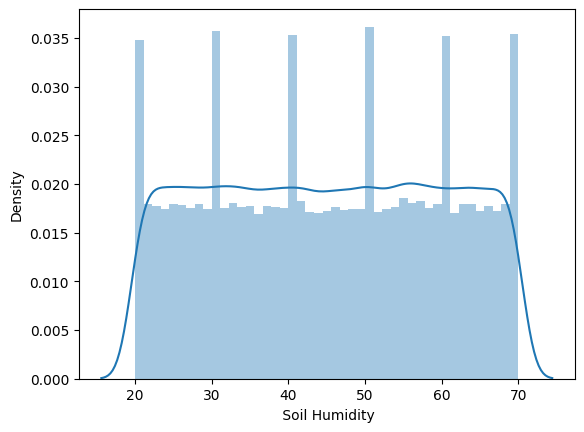

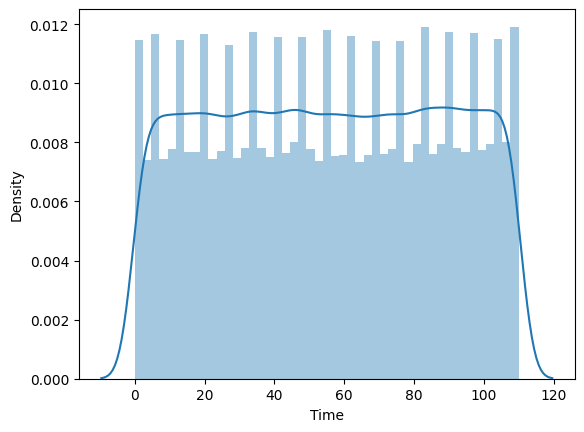

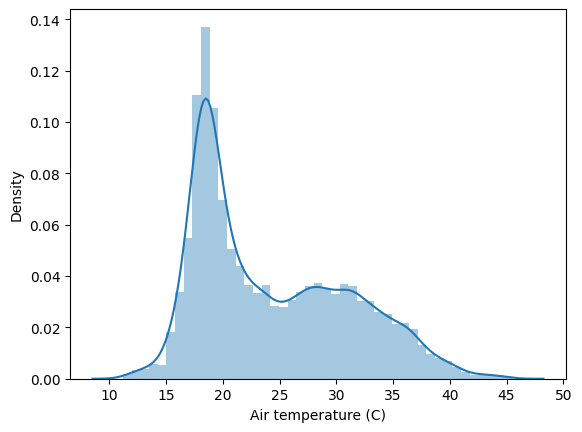

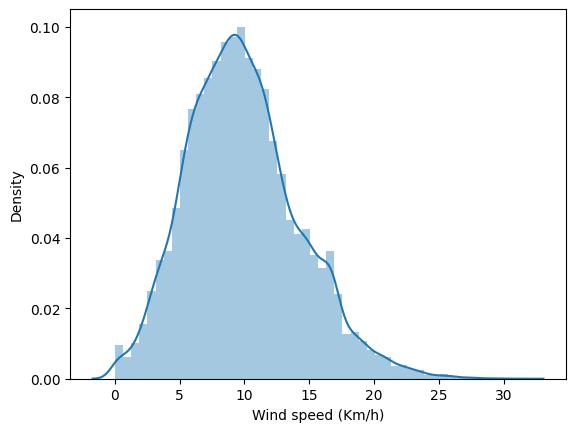

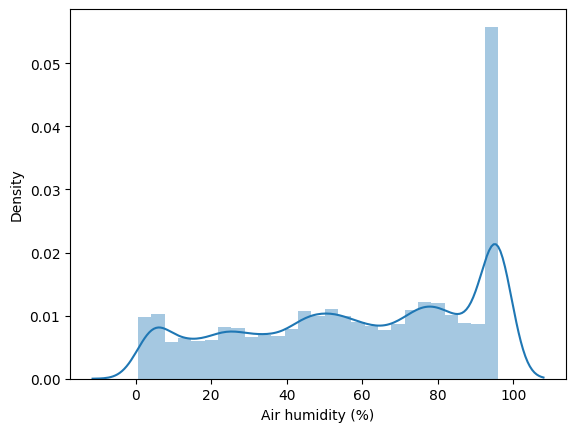

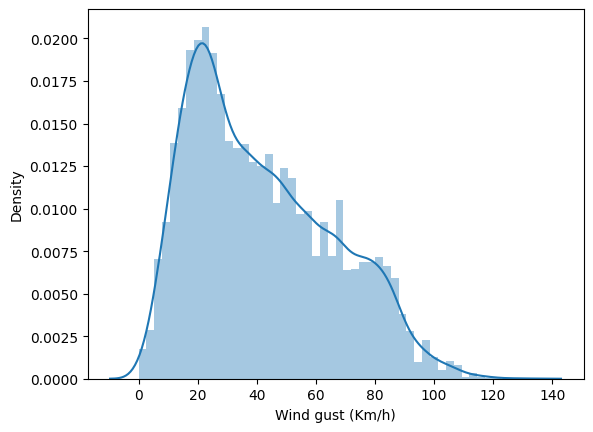

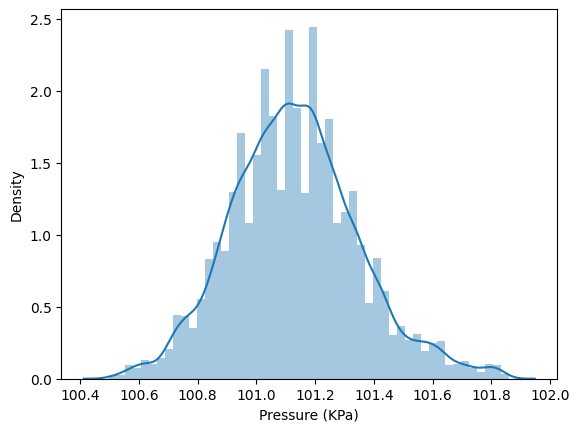

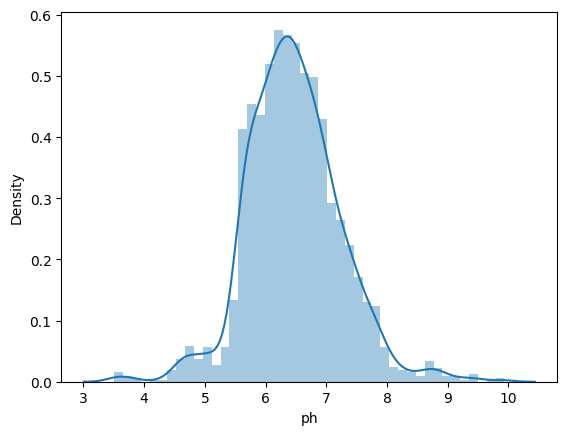

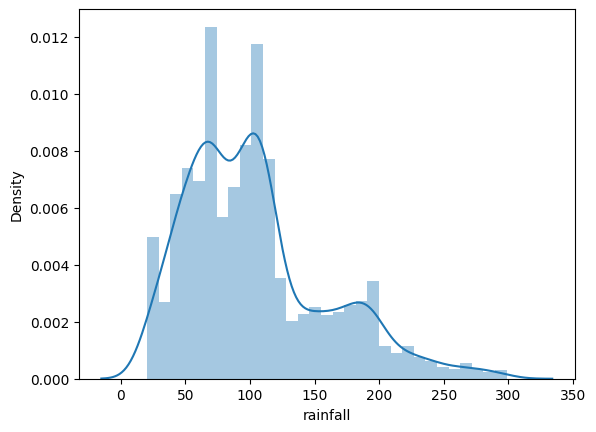

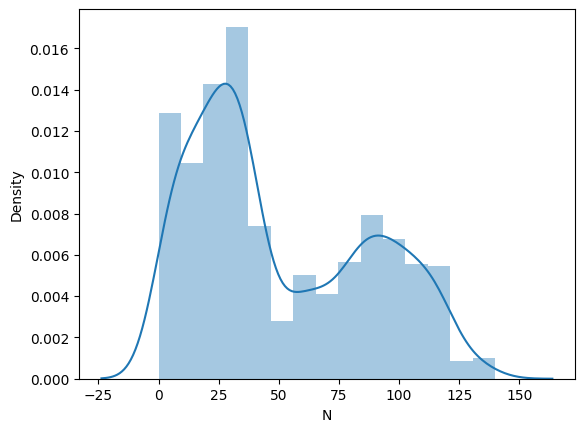

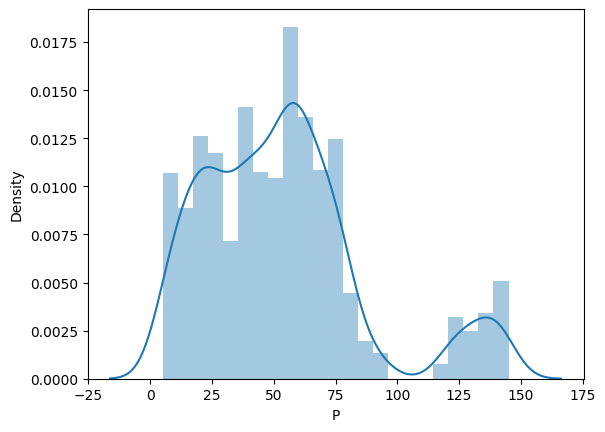

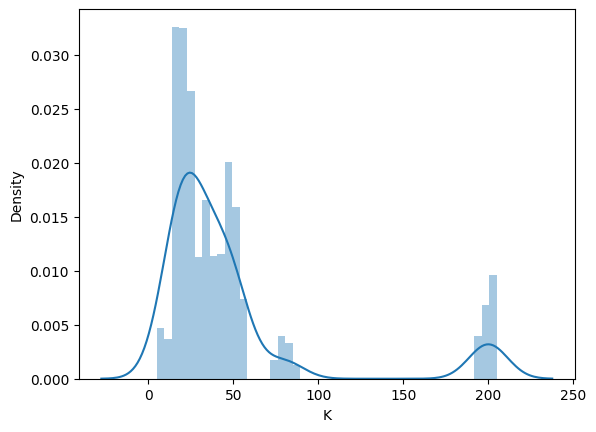

In [ ]:
def distplots(col):
  sns.distplot(df[col])
  plt.show()

for i in list(df.columns)[:-1]:
  distplots(i)

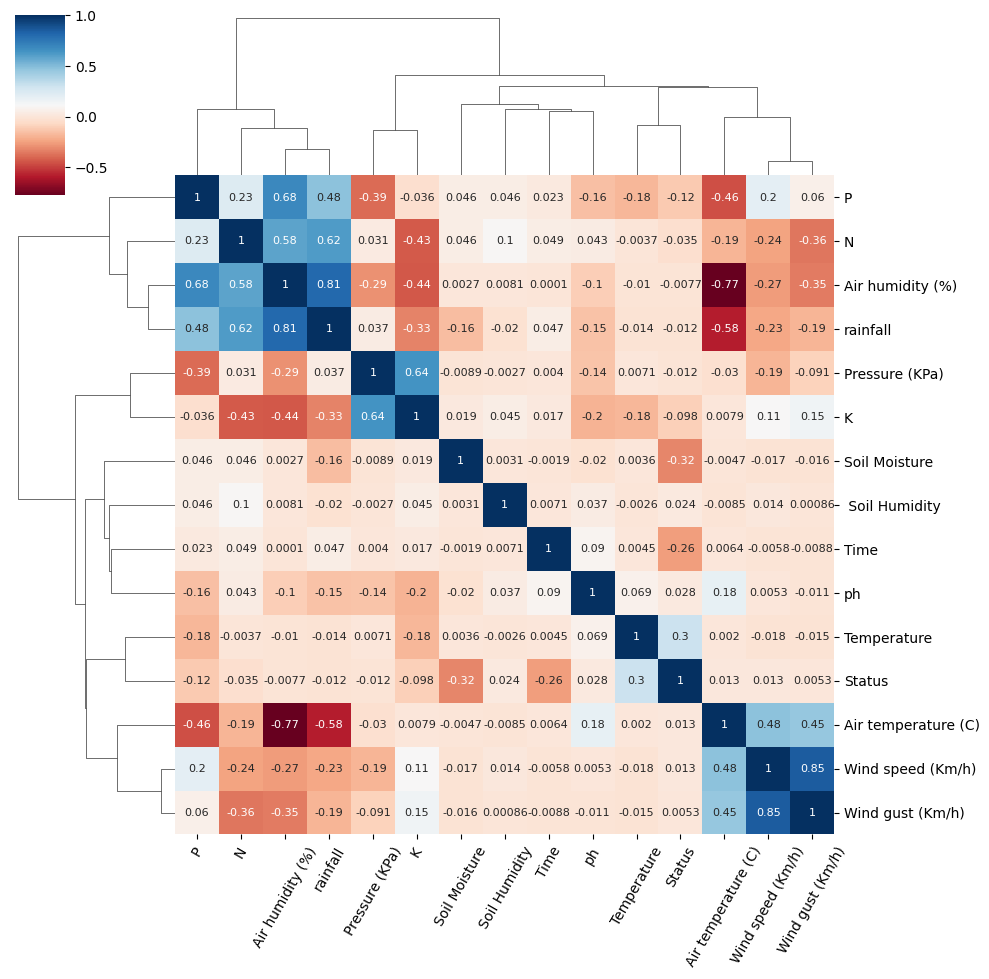

In [ ]:
g = sns.clustermap(scaled_df.corr(),
                   method = 'complete',
                   cmap   = 'RdBu',
                   annot  = True,
                   annot_kws = {'size': 8})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60);

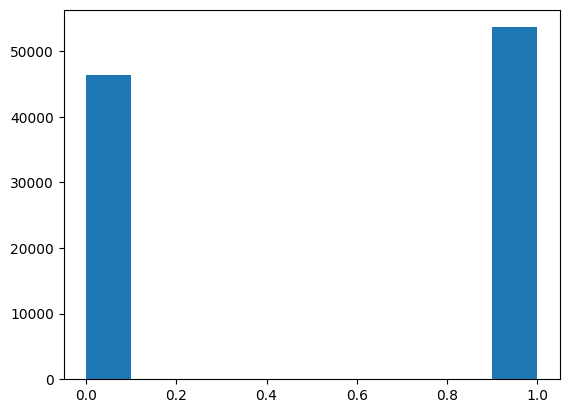

In [ ]:
plt.hist(scaled_df['Status'])
plt.show()

*SVM*

In [ ]:
x = scaled_df.iloc[:,:-1]
y = scaled_df.iloc[:,-1]

In [ ]:
#scaling the data
scaler = MinMaxScaler((-1,1))
#scaler = StandardScaler()
x=scaler.fit_transform(x)
y = y

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.3, random_state=7)

In [ ]:
# Apply KNN
from sklearn.neighbors import KNeighborsClassifier
model_knn3 = KNeighborsClassifier(n_neighbors=3)
knn = model_knn3.fit(x_train, y_train)
# Predicting Test Set N=3
y_pred = model_knn3.predict(x_test)
#Accuracy
accuracy_KNN = accuracy_score (y_test, y_pred)
print(f'Accuracy: {accuracy_KNN * 100:.2f}%')

Accuracy: 92.44%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92     13958
         1.0       0.93      0.93      0.93     16042

    accuracy                           0.92     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       0.92      0.92      0.92     30000



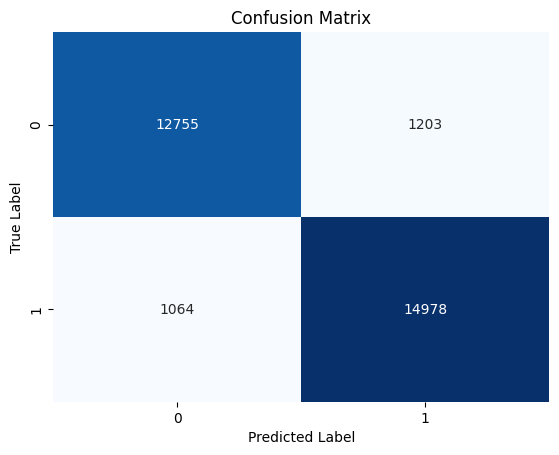

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
input_data = (5,23,27,4,21.44,5.8,28.38,22.67,101,7.375482851,224.0581164,98,47,37)

input_data_as_array = np.asarray(input_data)
input_data_reshaped = input_data_as_array.reshape(1,-1)
std_data = scaler.transform(input_data_reshaped)

prediction = model_knn3.predict(std_data)
print(prediction.round(4))

[1.]


In [ ]:
import joblib

joblib.dump(model_knn3, 'plant_watering_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']